In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib widget
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.features.breath_detection import BreathDetection
from eitprocessing.features.pixel_breath import PixelBreath
from eitprocessing.parameters.tidal_impedance_variation import TIV

### Load a sequence from file.

In [2]:
sequence = load_eit_data("tests/test_data/Draeger_Test.bin", vendor="draeger")

### Select a small portion of the sequence

In [3]:
ssequence = sequence.t[55940:55970]

### Perform breath detection on global impedance

In [4]:
bd = BreathDetection()
breaths = bd.find_breaths(ssequence.continuous_data["global_impedance_(raw)"])

In [5]:
continuous_data = ssequence.continuous_data["global_impedance_(raw)"].values
continuous_time = ssequence.continuous_data["global_impedance_(raw)"].time
continuous_start_indices = [
    np.argmax(continuous_time == start_time) for start_time in [breath.start_time for breath in breaths.values]
]
continuous_middle_indices = [
    np.argmax(continuous_time == middle_time) for middle_time in [breath.middle_time for breath in breaths.values]
]
continuous_end_indices = [
    np.argmax(continuous_time == end_time) for end_time in [breath.end_time for breath in breaths.values]
]

### Perform pixel breath detection on pixel impedance

In [6]:
pb = PixelBreath()
pixel_breaths = pb.find_pixel_breaths(
    eit_data=ssequence.eit_data["raw"],
    continuous_data=ssequence.continuous_data["global_impedance_(raw)"],
    sequence=ssequence,
)

In [7]:
pixel_data = ssequence.eit_data["raw"].pixel_impedance
_, n_rows, n_cols = pixel_data.shape
pixel_breaths = np.stack(pixel_breaths.values)

# Handle None values
pixel_start_indices = [
    np.argmax(ssequence.eit_data["raw"].time == start_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for start_time in [pixel_breath.start_time]
]

pixel_middle_indices = [
    np.argmax(ssequence.eit_data["raw"].time == middle_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for middle_time in [pixel_breath.middle_time]
]

pixel_end_indices = [
    np.argmax(ssequence.eit_data["raw"].time == end_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for end_time in [pixel_breath.end_time]
]

### Compute TIV with different TIV methods and timings

In [8]:
# TIV of global impedance determined on inspiratory limb of breath
tiv_result_continuous_inspiratory = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
)
tiv_result_continuous_inspiratory_values = np.stack(tiv_result_continuous_inspiratory.values)
# TIV of global impedance determined on expiratory limb of breath
tiv_result_continuous_expiratory = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
    tiv_method="expiratory",
)
tiv_result_continuous_expiratory_values = np.stack(tiv_result_continuous_expiratory.values)
# TIV of global impedance determined on mean of inspiratory and expiratory limb of breath
tiv_result_continuous_mean = TIV().compute_continuous_parameter(
    ssequence.continuous_data["global_impedance_(raw)"],
    tiv_method="mean",
)
tiv_result_continuous_mean_values = np.stack(tiv_result_continuous_mean.values)

# TIV of pixel impedance determined on inspiratory limb of pixel breath based on pixel breath timings
tiv_result_pixel_inspiratory = TIV().compute_pixel_parameter(
    ssequence.eit_data["raw"],
    ssequence.continuous_data["global_impedance_(raw)"],
    ssequence,
    tiv_method="inspiratory",
    tiv_timing="pixel",
    result_label="inspiratory pixel tiv",
)
tiv_result_pixel_inspiratory_values = (
    np.empty((0, n_rows, n_cols))
    if not len(tiv_result_pixel_inspiratory.values)
    else np.stack(tiv_result_pixel_inspiratory.values)
)
# TIV of pixel impedance determined on inspiratory limb of pixel breath based on continuous breath timings
tiv_result_pixel_inspiratory_continuous_timing = TIV().compute_pixel_parameter(
    ssequence.eit_data["raw"],
    ssequence.continuous_data["global_impedance_(raw)"],
    ssequence,
    tiv_method="inspiratory",
    tiv_timing="continuous",
    result_label="inspiratory pixel tiv with continuous timing",
)

tiv_result_pixel_inspiratory_continuous_timing_values = (
    np.empty((0, n_rows, n_cols))
    if not len(tiv_result_pixel_inspiratory_continuous_timing.values)
    else np.stack(tiv_result_pixel_inspiratory_continuous_timing.values)
)

### Visualise global impedance TIV

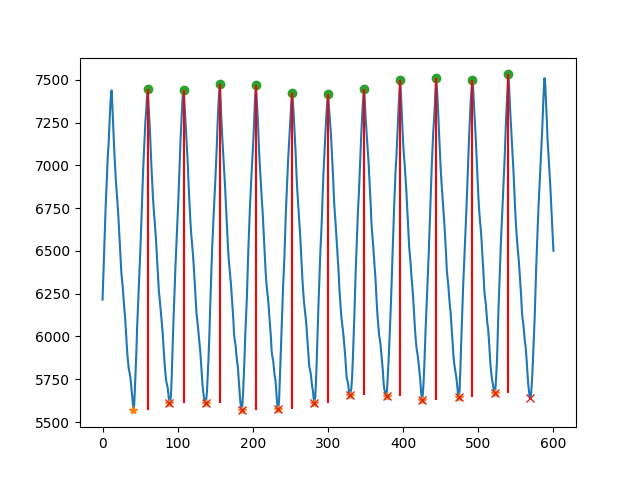

In [9]:
## Plot results of inspiratory TIV method on global impedance

plt.figure()
plt.plot(continuous_data)
plt.plot(continuous_start_indices, continuous_data[continuous_start_indices], "*")
plt.plot(continuous_middle_indices, continuous_data[continuous_middle_indices], "o")
plt.plot(continuous_end_indices, continuous_data[continuous_end_indices], "x")

# Plot vertical lines at middle_indices
for i, mid_idx in enumerate(np.searchsorted(continuous_time, tiv_result_continuous_inspiratory.time)):
    plt.vlines(
        x=mid_idx,
        ymin=continuous_data[mid_idx] - tiv_result_continuous_inspiratory[i].values,
        ymax=continuous_data[mid_idx],
        color="r",
        linestyle="-",
        label="TIV",
    )

### Visualise pixel TIV based on pixel breath timings

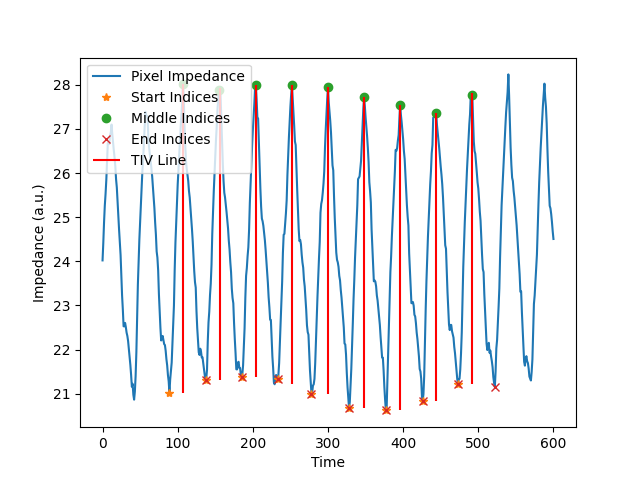

In [10]:
## Plot results of inspiratory TIV method of a single pixel

pixel_row = 12
pixel_col = 12

pixel_data = ssequence.eit_data["raw"].pixel_impedance

tiv_result_pixel_inspiratory_time = (
    np.empty((0, n_rows, n_cols))
    if not len(tiv_result_pixel_inspiratory.time)
    else np.stack(tiv_result_pixel_inspiratory.time)
)

plt.figure()
plt.plot(pixel_data[:, pixel_row, pixel_col], label="Pixel Impedance")
plt.plot(pixel_start_indices, pixel_data[pixel_start_indices, pixel_row, pixel_col], "*", label="Start Indices")
plt.plot(pixel_middle_indices, pixel_data[pixel_middle_indices, pixel_row, pixel_col], "o", label="Middle Indices")
plt.plot(pixel_end_indices, pixel_data[pixel_end_indices, pixel_row, pixel_col], "x", label="End Indices")

# Filter out None values from tiv_result_pixel_inspiratory_time for the specific pixel
valid_times = [time for time in tiv_result_pixel_inspiratory_time[:, pixel_row, pixel_col] if time is not None]

# Use np.searchsorted on the filtered times
mid_indices = np.searchsorted(ssequence.eit_data["raw"].time, valid_times)

# Plot vertical lines at middle indices
for i, mid_idx in enumerate(mid_indices):
    plt.vlines(
        x=mid_idx,
        ymin=(
            pixel_data[mid_idx, pixel_row, pixel_col] - tiv_result_pixel_inspiratory_values[i + 1, pixel_row, pixel_col]
        ),
        ymax=pixel_data[mid_idx, pixel_row, pixel_col],
        color="r",
        linestyle="-",
        label="TIV Line" if i == 0 else None,  # Label only once
    )

plt.xlabel("Time")
plt.ylabel("Impedance (a.u.)")
plt.legend()
plt.show()

### Visualise pixel TIV based on continuous breaths timings

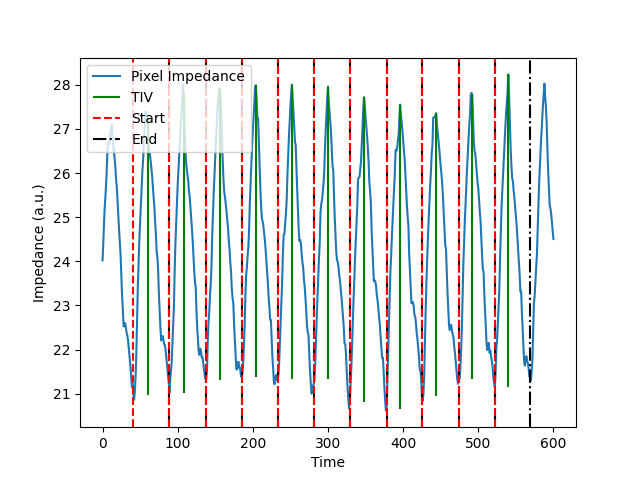

In [11]:
## Plot results of inspiratory TIV method of a single pixel based on the timing of the continuous breaths

plt.figure()
plt.plot(pixel_data[:, pixel_row, pixel_col], label="Pixel Impedance")

# Prepare the timing array for inspiratory TIV with continuous timing
tiv_result_pixel_inspiratory_continuous_timing_time = (
    np.empty((0, n_rows, n_cols))
    if not len(tiv_result_pixel_inspiratory_continuous_timing.time)
    else np.stack(tiv_result_pixel_inspiratory_continuous_timing.time)
)

# Plot vertical lines based on TIV timing values
valid_times = [
    time for time in tiv_result_pixel_inspiratory_continuous_timing_time[:, pixel_row, pixel_col] if time is not None
]

mid_indices = np.searchsorted(continuous_time, valid_times)

for i, glo_mid_idx in enumerate(mid_indices):
    plt.vlines(
        x=glo_mid_idx,
        ymin=(
            pixel_data[glo_mid_idx, pixel_row, pixel_col]
            - tiv_result_pixel_inspiratory_continuous_timing_values[i, pixel_row, pixel_col]
        ),
        ymax=pixel_data[glo_mid_idx, pixel_row, pixel_col],
        color="g",
        linestyle="-",
        label="TIV" if i == 0 else None,  # Label only once
    )

# Add vertical lines for continuous start and end indices
for start_idx, end_idx in zip(continuous_start_indices, continuous_end_indices, strict=True):
    plt.axvline(start_idx, color="red", ls="--", label="Start" if start_idx == continuous_start_indices[0] else None)
    plt.axvline(end_idx, color="black", ls="-.", label="End" if end_idx == continuous_end_indices[0] else None)

plt.xlabel("Time")
plt.ylabel("Impedance (a.u.)")
plt.legend()
plt.show()